In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [258]:
# load
loan_result=pd.read_csv("../data/loan_result.csv")
log_data=pd.read_csv("../data/log_data.csv")
user_spec=pd.read_csv("../data/user_spec.csv")

# columns localize
loan_result.columns=['신청서_번호', '한도조회_일시', '금융사_번호', '상품_번호', '승인한도', '승인금리', '신청_여부(y)']
log_data.columns=['유저_번호', '행동명', '행동일시', '운영체제', '앱_버전', '일_코드']
user_spec.columns=['신청서_번호', '유저_번호', '유저_생년월일', '유저_성별', '생성일시', '한도조회_당시_유저_신용점수', '연소득', '근로형태', '입사연월', '고용형태', '주거소유형태', '대출희망금액', '대출_목적', '개인회생자_여부', '개인회생자_납입_완료_여부', '기대출수', '기대출금액'] # 건강보험 타입이 정의서에는 있는데 데이터엔 없는듯

In [259]:
log_data.shape

(17843993, 6)

In [260]:
# log_data sort by time(asc)
log_data=log_data.sort_values('행동일시').reset_index(drop=True)
log_data.head()

,유저_번호,행동명,행동일시,운영체제,앱_버전,일_코드
0,125129,UseLoanManage,2022-03-01 00:00:00,Android,3.8.0,2022-03-01
1,385811,Login,2022-03-01 00:00:00,Android,3.8.0,2022-03-01
2,720911,OpenApp,2022-03-01 00:00:00,iOS,3.6.0,2022-03-01
3,706858,UseLoanManage,2022-03-01 00:00:03,Android,3.8.0,2022-03-01
4,512341,EndLoanApply,2022-03-01 00:00:03,Android,3.8.0,2022-03-01


In [261]:
# Datetime 변환
log_data['행동일시'] = pd.to_datetime(log_data['행동일시'])
log_data['일_코드'] = pd.to_datetime(log_data['일_코드'])
loan_result['한도조회_일시'] = pd.to_datetime(loan_result['한도조회_일시'])
user_spec['생성일시'] = pd.to_datetime(user_spec['생성일시'])

In [262]:
# user_spec & log_data
users=set(user_spec['유저_번호'])
log_user=set(log_data['유저_번호'])
count=[]

for num in log_user:
    if num in users:
        count.append(num)

print(len(count))

370436


## 주요 경로
### 1. 경로의 종류
#### 1) 5개의 스크린
- 한도조회시작(StartLoanApply), 대출관리서비스 이용(UseLoanManage), 여윳돈 계산기 이용(UsePrepayCalc), DSR 계산기 이용(UseDSRCalc), KCB 신용정보 조회(GetCreditInfo)
- ['StartLoanApply', 'UseLoanManage', 'UsePrepayCalc', 'UseDSRCalc', 'GetCreditInfo']
#### 2) 시작점-종료점
- OpenApp부터 그 다음 OpenApp 까지

### 2. 슬라이싱
- 0. log_data에서 5개의 스크린만 뽑기
- 1. log_data를 user별로 
- 2. OpenApp 앞뒤를 쪼개서 여러개의 리스트로 합친
- 3. 전체 route_list에 넣음
- 4. 겹치는 것의 종류 확인
    + 5!+4!+3!+2!+1!=153 보다 많다면 쪼개야하나.. 일단 최대 길이 찾아서 대기..
- 5. value_counts()

In [263]:
screens=['StartLoanApply', 'UseLoanManage', 'UsePrepayCalc', 'UseDSRCalc', 'GetCreditInfo']
main_route_log_df=log_data[(log_data['행동명']=="OpenApp")|
                           (log_data['행동명']==screens[0])|
                           (log_data['행동명']==screens[1])|
                           (log_data['행동명']==screens[2])|
                           (log_data['행동명']==screens[3])|
                           (log_data['행동명']==screens[4])
                           ]
main_route_log_df.reset_index(drop=True, inplace=True)
len(main_route_log_df), len(log_data), len(set(main_route_log_df['유저_번호']))

(9587604, 17843993, 574778)

#### OpenApp 기준 슬라이싱

In [266]:
users=list(set(main_route_log_df['유저_번호']))
route_list=[]
user_list=[]

# target의 idx들(복수)를 list로 추출
def list_idx(arr, target):
    return [i for i in range(len(arr)) if arr[i]==target]

# 유저별로 OpenApp 기준 슬라이싱
for i in tqdm(range(len(users))):
    df=main_route_log_df[main_route_log_df['유저_번호']==users[i]]
    idx_list=list_idx(list(df['행동명']), 'OpenApp')
    if len(idx_list)>0 and len(df)>0:
        for i in range(len(idx_list)):
            start=idx_list[i]
            try:
                end=idx_list[i+1]
            except:
                end=len(df)
            route_list.append(list(df['행동명'].iloc[start:end]))
            user_list.append(users[i])
        # route_list.append([df['행동명'].iloc[idx_list[i]:min(idx_list[i+1], len(df))] for i in range(len(idx_list))])
    else: continue

100%|██████████| 574778/574778 [35:09<00:00, 272.47it/s]   


- route_list와 user_list가 같은 idx를 공유

In [267]:
len(route_list), len(user_list) # 같아야 함

(3460762, 3460762)

In [269]:
np.save('../data/route_list', np.array(route_list)) # 모든 루트
np.save('../data/user_list', np.array(user_list)) # 해당 루트의 유저 번호(동일 idx)

## 경로
- 5개의 스크린을 기준으로 1~5개의 순서에 대한 permutation을 돌림
- 0개부터 5개까지 [1 + 5 + 5*4 + 5*4*3 + 5*4*3*2 + 5*4*3*2*1 = **326**]
- **326가지의 루트**가 있다

In [270]:
from asyncore import poll3
from itertools import permutations
from itertools import combinations

log_init=[('StartLoanApply'), ('UseLoanManage'), ('UsePrepayCalc'), ('UseDSRCalc'), ('GetCreditInfo')]
log_columns=[('StartLoanApply'), ('UseLoanManage'), ('UsePrepayCalc'), ('UseDSRCalc'), ('GetCreditInfo')]

p2=list(permutations(log_init, 2))
p3=list(permutations(log_init, 3))
p4=list(permutations(log_init, 4))
p5=list(permutations(log_init, 5))

n1=5
n2=len(p2)
n3=len(p3)
n4=len(p4)
n5=len(p5)

for arr in p2:
    log_columns.append(arr)
for arr in p3:
    log_columns.append(arr)
for arr in p4:
    log_columns.append(arr)
for arr in p5:
    log_columns.append(arr)
    
log_columns.append((''))

len(log_columns), n1+n2+n3+n4+n5+1 # 5개의 스크린의 1, 2, 3, 4, 5 순열 합

(326, 326)

- 아무 활동도 하지 않은 경로의 개수

In [303]:
log_ngram_df=pd.DataFrame([0]*len(log_columns), index=log_columns, columns=['count'])
users_noroute=[]
count=0
for i in range(len(route_list)):
    if len(route_list[i])==1: 
        count+=1
        users_noroute.append(user_list[i])
log_ngram_df.loc['']=count

print("%d명의 유저가 경로가 없음."%(len(users_noroute)))
log_ngram_df

1050222명의 유저가 경로가 없음.


,count
StartLoanApply,0
UseLoanManage,0
UsePrepayCalc,0
UseDSRCalc,0
GetCreditInfo,0
...,...
"(GetCreditInfo, UseDSRCalc, UseLoanManage, StartLoanApply, UsePrepayCalc)",0
"(GetCreditInfo, UseDSRCalc, UseLoanManage, UsePrepayCalc, StartLoanApply)",0
"(GetCreditInfo, UseDSRCalc, UsePrepayCalc, StartLoanApply, UseLoanManage)",0
"(GetCreditInfo, UseDSRCalc, UsePrepayCalc, UseLoanManage, StartLoanApply)",0


In [304]:
users_noroute[:5]

[7, 11, 17, 24, 25]

In [272]:
# 역색인용 dict
log_dict={}
for col in log_columns:
    log_dict[str(col)]=[]
    
len(log_dict.keys())

326

In [273]:
# screens=['StartLoanApply', 'UseLoanManage', 'UsePrepayCalc', 'UseDSRCalc', 'GetCreditInfo']

# 조합별 개수 count와 역색인용 Dict 함께 돌리기
for i in tqdm(range(len(route_list))):
    if len(route_list[i])==1: continue
    for n in range(1, len(route_list[i])):
        # 원소 안의 2~5개의 순서 지킨 조합에서
            # range에서도 1 빠지고 슬라이싱에서도 1 빠져서 머리 터지는 줄
        for k in range(n+1, min(n+1+5, len(route_list[i])+1)):
            # print(tuple(route_list[i][n:k]))
            # 하나일 때랑 여러개 일 때 들어가는 [] 계층이 다름
            if len(route_list[i][n:k])==1: 
                # count
                log_ngram_df.loc[route_list[i][n:k]]+=1
                # dict
                log_dict[str(route_list[i][n:k][0])].append(i)
            else: 
                try: 
                    # count
                    log_ngram_df.loc[[tuple(route_list[i][n:k])]]+=1
                    # dict
                    log_dict[str(tuple(route_list[i][n:k]))].append(i)
                except KeyError:
                    continue
# 역색인을 위한 dict 중복 제거
for key in list(log_dict.keys()):
    log_dict[key]=list(set(log_dict[key]))

log_ngram_df.head()

100%|██████████| 3460762/3460762 [2:34:41<00:00, 372.87it/s]    


,count
StartLoanApply,1694042
UseLoanManage,1423936
UsePrepayCalc,5783
UseDSRCalc,3660
GetCreditInfo,2113762


In [369]:
log_dict_user=log_dict.copy()

for key in log_dict.keys():
    users=[]
    for i in range(len(log_dict[key])):
        users.append(user_list[log_dict[key][i]])
        
    users=list(set(users))
    users.sort()
    
    log_dict_user[key]=users

In [370]:
log_dict_user[str(log_columns[6])]

[1, 7, 12, 19]

In [372]:
log_dict[str(log_columns[6])]

[264896, 562407, 940087, 1654936, 2229883, 899198]

In [275]:
log_ngram_df.to_csv("../data/log_ngram_df.csv", index=False)
np.save('../data/log_columns.npy' ,log_columns)

import pickle

with open('../data/log_dict.pkl','wb') as f:
    pickle.dump(log_dict,f)
    
with open('../data/log_dict_user.pkl','wb') as f:
    pickle.dump(log_dict_user,f)

# with open('data_dict.pkl','rb') as f:
#     mydict = pickle.load(f)

---

## 시각화

- df로 그래프 그려줌

In [276]:
def plot_log_cols(log_columns_df, n=-1, rotation=45):
    if n==-1: n=len(log_columns_df)
    log_columns_str=[str(x) for x in log_columns_df.index]
    plt.bar(log_columns_str[:n], log_columns_df.iloc[:n]['count'])
    plt.xticks(log_columns_str[:n], rotation=rotation, fontsize=8)
    plt.show()

In [277]:
n1, n2, n3, n4, n5

(5, 20, 60, 120, 120)

In [278]:
log_ngram_df.iloc[:n1]['count']

StartLoanApply    1694042
UseLoanManage     1423936
UsePrepayCalc        5783
UseDSRCalc           3660
GetCreditInfo     2113762
Name: count, dtype: int64

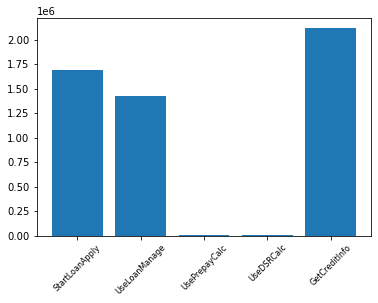

In [279]:
plot_log_cols(log_ngram_df, n1)

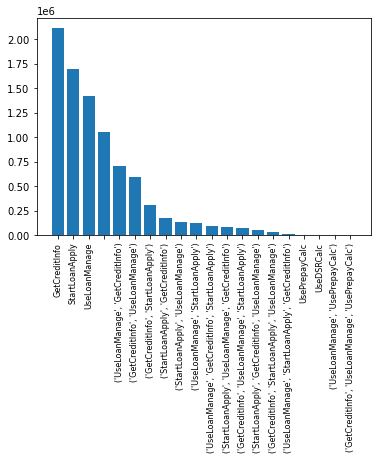

In [300]:
# 개수 순으로 정렬
log_ngram_sort_df=log_ngram_df.sort_values(by=['count'], ascending=False)
plot_log_cols(log_ngram_sort_df, n=20, rotation=90)


In [301]:
log_ngram_sort_df.head(20) 

,count
GetCreditInfo,2113762
StartLoanApply,1694042
UseLoanManage,1423936
,1050222
"(UseLoanManage, GetCreditInfo)",704835
"(GetCreditInfo, UseLoanManage)",593102
"(GetCreditInfo, StartLoanApply)",309160
"(StartLoanApply, GetCreditInfo)",175437
"(StartLoanApply, UseLoanManage)",138206
"(UseLoanManage, StartLoanApply)",127845


- 상위 15% 파싱(min 190, count 48)

In [323]:
log_ngram_sort_df_15=log_ngram_sort_df[:int(len(log_ngram_sort_df)*0.15)]
log_ngram_sort_df_15.describe()

,count
count,4.800000e+01
mean,1.814121e+05
std,4.594921e+05
min,1.900000e+02
25%,3.455000e+02
50%,1.107500e+03
75%,7.347550e+04
max,2.113762e+06


- 첫 스크린 별로

In [283]:
screens
# SL, UL, UP, UD, GC

['StartLoanApply',
 'UseLoanManage',
 'UsePrepayCalc',
 'UseDSRCalc',
 'GetCreditInfo']

In [324]:
SL=[x for x in log_ngram_sort_df_15.drop(['']).index if x[0]==screens[0] or x==screens[0]]
UL=[x for x in log_ngram_sort_df_15.drop(['']).index if x[0]==screens[1] or x==screens[1]]
UP=[x for x in log_ngram_sort_df_15.drop(['']).index if x[0]==screens[2] or x==screens[2]]
UD=[x for x in log_ngram_sort_df_15.drop(['']).index if x[0]==screens[3] or x==screens[3]]
GC=[x for x in log_ngram_sort_df_15.drop(['']).index if x[0]==screens[4] or x==screens[4]]

In [325]:
# log_ngram_sort_df_15.loc[[list(list(SL)[0])]]
SL_df=log_ngram_sort_df_15.loc[list(SL)]
UL_df=log_ngram_sort_df_15.loc[list(UL)]
UP_df=log_ngram_sort_df_15.loc[list(UP)]
UD_df=log_ngram_sort_df_15.loc[list(UD)]
GC_df=log_ngram_sort_df_15.loc[list(GC)]

In [326]:
def plot_log_cols_info(log_columns_df, n=-1, rotation=45):
    if n==-1: n=len(log_columns_df)
    log_columns_str=[str(x) for x in log_columns_df.index]
    plt.title(log_columns_str[0]+"의 분포")
    plt.bar(log_columns_str[:n], log_columns_df.iloc[:n]['count'])
    plt.xticks(log_columns_str[:n], rotation=rotation, fontsize=8)
    plt.show()
    print(log_columns_df.describe())

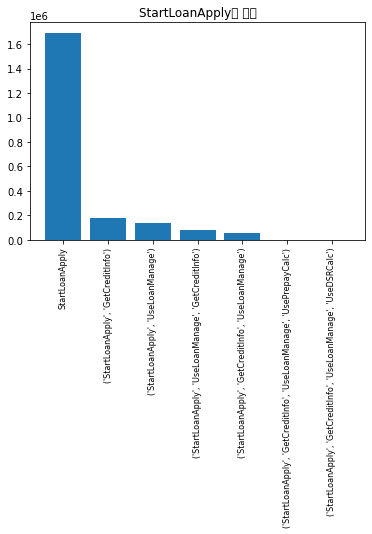

              count
count  7.000000e+00
mean   3.059449e+05
std    6.155802e+05
min    2.900000e+02
25%    2.725800e+04
50%    7.912300e+04
75%    1.568215e+05
max    1.694042e+06


In [327]:
plot_log_cols_info(SL_df, rotation=90)

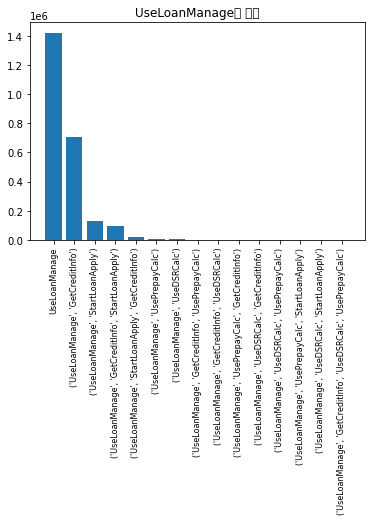

              count
count  1.500000e+01
mean   1.582213e+05
std    3.940641e+05
min    1.960000e+02
25%    3.650000e+02
50%    1.033000e+03
75%    5.394850e+04
max    1.423936e+06


(None,)

In [328]:
plot_log_cols_info(UL_df, rotation=90), 


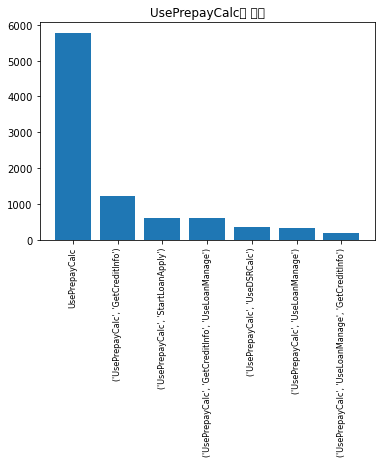

             count
count     7.000000
mean   1296.428571
std    2007.228509
min     190.000000
25%     335.500000
50%     593.000000
75%     919.000000
max    5783.000000


(None,)

In [329]:
plot_log_cols_info(UP_df, rotation=90), 

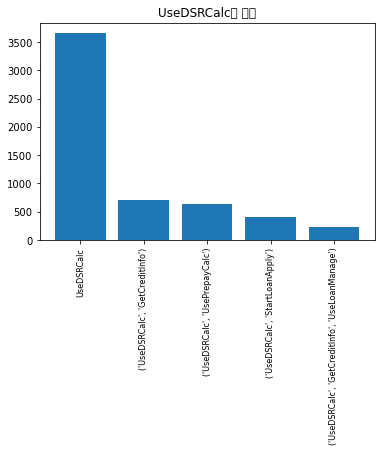

             count
count     5.000000
mean   1129.000000
std    1427.840677
min     226.000000
25%     410.000000
50%     633.000000
75%     716.000000
max    3660.000000


(None,)

In [330]:
plot_log_cols_info(UD_df, rotation=90), 

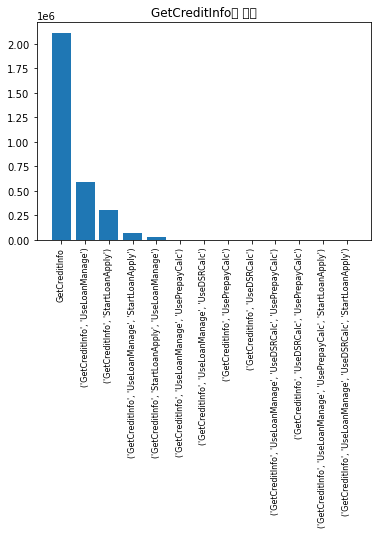

              count
count  1.300000e+01
mean   2.406082e+05
std    5.894178e+05
min    2.100000e+02
25%    2.890000e+02
50%    1.828000e+03
75%    7.159300e+04
max    2.113762e+06


In [331]:
plot_log_cols_info(GC_df, rotation=90)

- 색인

In [338]:
log_columns[:10]

['StartLoanApply',
 'UseLoanManage',
 'UsePrepayCalc',
 'UseDSRCalc',
 'GetCreditInfo',
 ('StartLoanApply', 'UseLoanManage'),
 ('StartLoanApply', 'UsePrepayCalc'),
 ('StartLoanApply', 'UseDSRCalc'),
 ('StartLoanApply', 'GetCreditInfo'),
 ('UseLoanManage', 'StartLoanApply')]

In [373]:
log_dict[str(tuple(log_columns[6]))], log_dict_user[str(tuple(log_columns[6]))], log_columns[6]

([264896, 562407, 940087, 1654936, 2229883, 899198],
 [1, 7, 12, 19],
 ('StartLoanApply', 'UsePrepayCalc'))

In [336]:
# 중요도?
log_ngram_sort_df_15['rank']=[x for x in range(1, 49)]
log_ngram_sort_df_15

,count,rank
GetCreditInfo,2113762,1
StartLoanApply,1694042,2
UseLoanManage,1423936,3
,1050222,4
"(UseLoanManage, GetCreditInfo)",704835,5
"(GetCreditInfo, UseLoanManage)",593102,6
"(GetCreditInfo, StartLoanApply)",309160,7
"(StartLoanApply, GetCreditInfo)",175437,8
"(StartLoanApply, UseLoanManage)",138206,9
"(UseLoanManage, StartLoanApply)",127845,10
